# Projeto 2
## Introdução a Data Science
### Alunos
Gabriel de Melo Evangelista (gme@cin.ufpe.br)

Maria Luísa Leandro de Lima (mlll@cin.ufpe.br)
### Tema: Powerlifting
https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

### Imports

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Leitura dos dados limpos 

In [75]:
df = pd.read_csv('../powerlifting_clean.csv')

Como o peso do atleta é um atributo extremamente interessante de se analisar para efeitos de comparação com seus feitos de levantamento, iremos tentar prever tal peso baseado em outros atributos das competições. Logo, para a classificação, a coluna BodyweightKg_dist será definida como categórica e será nossa label.

In [76]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
        df[str(col + "C")] = df[col].cat.codes

In [77]:
df.dtypes

Name                  category
Sex                      int64
Event                 category
Equipment             category
Division              category
BodyweightKg           float64
WeightClassKg         category
Best3SquatKg           float64
Best3BenchKg           float64
Best3DeadliftKg        float64
TotalKg                float64
Place                    int64
Dots                   float64
Wilks                  float64
Glossbrenner           float64
Goodlift               float64
EquipmentC                int8
DivisionC                int16
WeightClassKgC           int16
PlaceC                   int64
NameC                    int32
Age                    float64
Age_log                float64
BodyweightKg_log       float64
total_bodyweight       float64
BodyweightKg_dist     category
Age_dist              category
EventC                    int8
BodyweightKg_distC        int8
Age_distC                 int8
dtype: object

### 1. Escolha da Coluna

Como expresso no outro notebook, a coluna BodyweightKg_dist será utilizada para classificação. 

As colunas Dots, Glossbrenner, Wilks e Goodlift não serão usadas pois em seus cálculos o peso corporal do atleta é usado.

In [95]:
data = df[['Sex', 'DivisionC', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'PlaceC', 'Age','BodyweightKg']]

In [96]:
X = df[['Sex', 'DivisionC', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'PlaceC', 'Age']]
y = df['BodyweightKg']

In [97]:
y

0          58.30
1          73.10
2          66.65
3         102.55
4          53.60
           ...  
568805     70.83
568806     79.48
568807     83.23
568808     75.36
568809    124.53
Name: BodyweightKg, Length: 568810, dtype: float64

In [98]:
X.dtypes

Sex                  int64
DivisionC            int16
Best3SquatKg       float64
Best3BenchKg       float64
Best3DeadliftKg    float64
TotalKg            float64
PlaceC               int64
Age                float64
dtype: object

As features utilizadas são colocadas na matriz X enquanto que a coluna a ser prevista é colocada no y.

In [99]:
y.value_counts()

82.50     6677
90.00     6246
75.00     5931
100.00    4914
67.50     4908
          ... 
113.42       1
106.58       1
152.64       1
140.72       1
139.32       1
Name: BodyweightKg, Length: 9771, dtype: int64

### 2. Entendimento dos dados

In [2]:
from sklearn.decomposition import PCA
import sklearn
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# data = PCA(n_components = 2).fit_transform(X_scaled)

In [3]:
def viz(viz_tecnique, params, data, scaler):
    reducer = None
    scale = scaler()
    X_scaled = scale.fit_transform(data.drop('BodyweightKg_dist', axis = 1))
    if viz_tecnique == sklearn.decomposition.PCA:
        reducer = viz_tecnique(n_components = 2)
    elif viz_tecnique == umap.UMAP:
        reducer = viz_tecnique(**params)
    data_reduced = reducer.fit_transform(X_scaled)

    color_label = {'(38.049, 64.09]': 'blue', '(64.09, 74.1]': 'red', '(99.1, 163.9]': 'green', '(84.9, 99.1]': 'magenta', '(74.1, 84.9]': 'yellow'}

    label_color = [color_label[x] for x in data['BodyweightKg_dist']]

    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=label_color)
    team_patches = [mpatches.Patch(color=color, label=team) for team, color in color_label.items()]
    plt.legend(handles=team_patches, loc='upper right')
    plt.show()

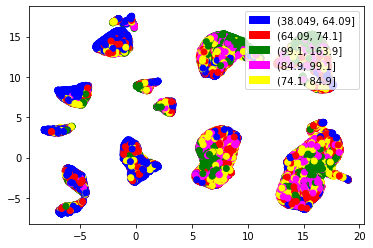

In [18]:
viz(umap.UMAP, {'n_neighbors':50}, data.sample(frac=0.1), MinMaxScaler)

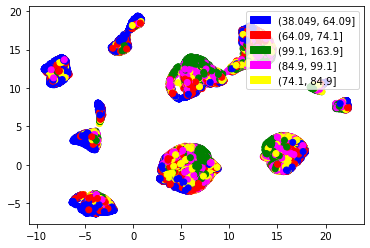

In [34]:
viz(umap.UMAP, {'n_neighbors':100}, data.sample(frac=0.1), MinMaxScaler)

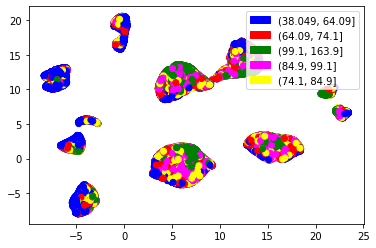

In [35]:
viz(umap.UMAP, {'n_neighbors':150}, data.sample(frac=0.1), MinMaxScaler)

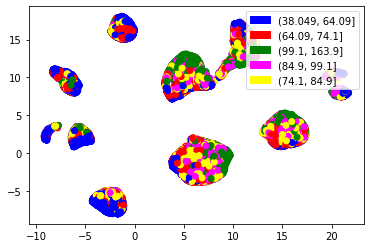

In [36]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'manhattan'}, data.sample(frac=0.1), MinMaxScaler)

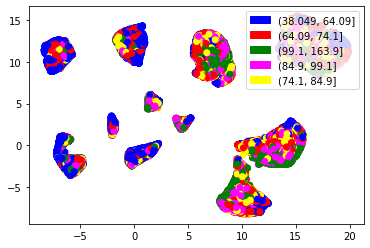

In [37]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'cosine'}, data.sample(frac=0.1), MinMaxScaler)

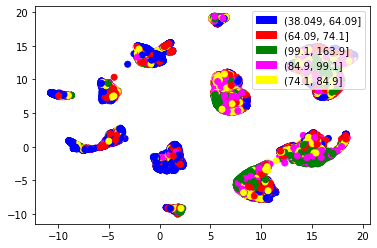

In [38]:
viz(umap.UMAP, {'n_neighbors':100, 'metric': 'chebyshev'}, data.sample(frac=0.1), MinMaxScaler)

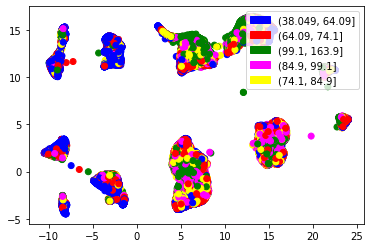

In [39]:
viz(umap.UMAP, {'n_neighbors':200, 'metric': 'chebyshev'}, data.sample(frac=0.1), MinMaxScaler)

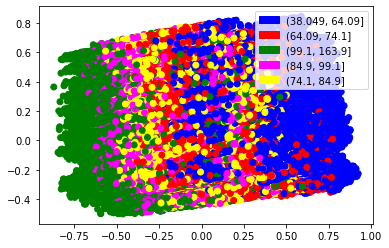

In [19]:
viz(PCA, {},data, MinMaxScaler)

In [20]:
data.shape

(568810, 9)

In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# scale = MinMaxScaler()
# X_scaled = scale.fit_transform(data.drop('Bodyweight_dist', axis = 1))
kmeans = KMeans(n_clusters=5)
kmeans.fit(data.drop('BodyweightKg_dist', axis = 1))

KMeans(n_clusters=5)

<Figure size 720x504 with 0 Axes>

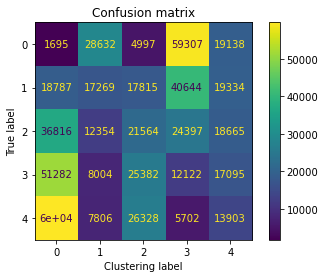

InvalidIndexError: (slice(None, None, None), 0)

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, kmeans.labels_)

plt.figure(figsize = (10,7))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

plt.scatter(data.drop('BodyweightKg_dist', axis = 1)[:, 0], data.drop('BodyweightKg_dist', axis = 1)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7)


### 3. Separação dos dados

Para realizar a separação dos dados será utilizada a função "train_test_split" do sklearn.

Os dados serão separados em 50% para treino, 25% para validação e 25% para teste. Para isso, será utilizada a função 2 vezes como observado abaixo.

In [100]:
X_train, x_f, y_train, y_f = train_test_split(X, y, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(x_f, y_f, test_size = 0.5)

In [101]:
X.shape

(568810, 8)

In [102]:
X_train.shape

(284405, 8)

In [103]:
X_val.shape

(142202, 8)

In [104]:
X_test.shape

(142203, 8)

Percebe-se pelos prints acima que a divisão funcionou da forma esperada.

### 4. Seleção dos algoritmos

In [108]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error

In [109]:
def trainEval(model, X_train, y_train, X_val, y_val):
    a = model().fit(X_train, y_train)
    y_p = a.predict(X_val)
    print(mean_squared_error(y_p, y_val, squared=False))

In [110]:
trainEval(LinearRegression, X_train, y_train, X_val, y_val)

13.46359018272592


In [111]:
trainEval(Ridge, X_train, y_train, X_val, y_val)

13.463589784417657


In [112]:
trainEval(DecisionTreeRegressor, X_train, y_train, X_val, y_val)

18.07982445847779


In [113]:
trainEval(KNeighborsRegressor, X_train, y_train, X_val, y_val)

13.800042870756686


In [114]:
trainEval(XGBRegressor, X_train, y_train, X_val, y_val)

12.51758002085636


In [115]:
trainEval(RandomForestRegressor, X_train, y_train, X_val, y_val)

12.83191424574691


In [116]:
trainEval(LinearSVR, X_train, y_train, X_val, y_val)

13.720191637216754


c:\Users\GODZILLA\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [89]:
y_pred = tree.predict(X_val)

In [91]:
data.describe()

,Sex,DivisionC,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,PlaceC,Age
count,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000,568810.000000
mean,0.723514,1057.226093,175.282608,113.651458,196.450341,485.383884,28.012354,28.268291
std,0.447268,442.132516,50.785754,39.608544,49.093086,132.870017,29.547787,11.754245
min,0.000000,0.000000,15.880000,20.000000,20.410000,178.000000,0.000000,8.500000
25%,0.000000,627.000000,135.000000,80.000000,155.000000,375.000000,0.000000,19.500000
50%,1.000000,1311.000000,175.000000,115.000000,200.000000,492.500000,32.000000,24.500000
75%,1.000000,1386.000000,210.000000,142.500000,235.000000,587.500000,43.000000,34.000000
max,2.000000,1785.000000,367.500000,260.820000,380.000000,850.000000,119.000000,78.000000


In [90]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.47      0.44      0.45     15501
           1       0.65      0.54      0.59     17179
           2       0.36      0.32      0.34     15775
           3       0.26      0.25      0.26     14742
           4       0.22      0.23      0.22     14087
           5       0.20      0.21      0.20     13853
           6       0.18      0.20      0.19     12565
           7       0.19      0.22      0.20     12655
           8       0.21      0.23      0.22     13204
           9       0.24      0.27      0.26     12641

    accuracy                           0.30    142202
   macro avg       0.30      0.29      0.29    142202
weighted avg       0.31      0.30      0.31    142202



### MLFlow test

In [117]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

In [119]:
def train(in_alpha, in_l1_ratio):
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

    warnings.filterwarnings("ignore")
    np.random.seed(40)

    X_train, x_f, y_train, y_f = train_test_split(X, y, test_size = 0.5)
    X_val, X_test, y_val, y_test = train_test_split(x_f, y_f, test_size = 0.5)

    # Set default values if no alpha is provided
    if float(in_alpha) is None:
        alpha = 0.5
    else:
        alpha = float(in_alpha)

    # Set default values if no l1_ratio is provided
    if float(in_l1_ratio) is None:
        l1_ratio = 0.5
    else:
        l1_ratio = float(in_l1_ratio)

    with mlflow.start_run():
        # Execute ElasticNet
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(X_train, y_train)

        # Evaluate Metrics
        predicted_qualities = lr.predict(X_val)
        (rmse, mae, r2) = eval_metrics(y_val, predicted_qualities)

        # Print out metrics
        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        mlflow.sklearn.log_model(lr, "model")

In [120]:
train(0.5, 0.5)

Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 13.670594687069057
  MAE: 10.36417910435138
  R2: 0.563940139141448


In [68]:
train(0.4, 0.6)

Elasticnet model (alpha=0.400000, l1_ratio=0.600000):
  RMSE: 0.9241943189581605
  MAE: 0.7384616608162445
  R2: 0.5728755811989574


In [69]:
train(0.1, 0.2)

Elasticnet model (alpha=0.100000, l1_ratio=0.200000):
  RMSE: 0.9221311546100779
  MAE: 0.7363921989568428
  R2: 0.5747804711811142
